## Описание проекта


**Заказчик:** мобильное приложение по продаже продуктов питания

**Задачи:**

- Необходимо изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходят до покупки, а сколько — «застревают» на предыдущих шагах. На каких именно.

- Необходимо исследовать результаты A/A/B-теста. Дизайнеры захотели поменять шрифты в приложении. Решение должно быть принято по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необхоидмо выяснить, какой шрифт лучше.


Причины создани двух А-групп вместо одной: если две контрольные группы окажутся равны, можно быть уверенными в точности проведенного тестирования. Если же между значениями A и A есть существенные различия, это помогает обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.


## Загрузка библиотек и данных

In [1]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import math as mth
import matplotlib.pyplot as plt
import re
import seaborn as sns
from datetime import datetime
from scipy import stats as st

In [2]:
try:
     logs = pd.read_csv(r"D:\Проекты Яндекс.Практикум\DA\03 Сборный проект 2\logs_exp.csv", sep='\t' )
except: 
     logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
        
logs.head()        

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Каждая запись в логе — это действие пользователя, или событие. 
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Шаг 2. Подготовка данных

### Замена названий столбцов на более удобные:

In [3]:
logs.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in logs.columns]
logs

,event_name,device_i_d_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


### Проверка пропусков и типов данных:

In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_i_d_hash  244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
logs

,event_name,device_i_d_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [6]:
logs['date_time'] = pd.to_datetime(logs['event_timestamp'], unit='s')
logs.head()

#  аргумент unit='s', который указывает, что значения в eventtimestamp представлены в секундах с начала эпохи Unix. Если этого не сделать, то при получении дат из значений, везде будет 01.01.1970.

,event_name,device_i_d_hash,event_timestamp,exp_id,date_time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


Добавили столбец с датой и временем и верным типом данных

In [7]:
logs.duplicated().sum()

413

In [8]:
logs.drop_duplicates(inplace = True)
#Удаление явных дубликатов

In [9]:
logs.isna().sum()

event_name         0
device_i_d_hash    0
event_timestamp    0
exp_id             0
date_time          0
dtype: int64

Пропуски отсутствуют

### Добавление отдельного столбца с датой

In [10]:
logs['dt']=logs['date_time'].dt.date

In [11]:
logs.head()

,event_name,device_i_d_hash,event_timestamp,exp_id,date_time,dt
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [12]:
logs['dt'] = logs['dt'].astype('datetime64[ns]')

In [13]:
gr_246 = logs.query('exp_id == 246').copy()
us_246 = gr_246['device_i_d_hash'].unique()
us_246

array([4575588528974610257, 7416695313311560658, 8351860793733343758, ...,
       4876403292056911122, 6660805781687343085, 7823752606740475984],
      dtype=int64)

In [14]:
gr_247 = logs.query('exp_id == 247').copy()
us_247 = gr_247['device_i_d_hash'].unique()
us_247

array([1850981295691852772,  948465712512390382, 2140904690380565988, ...,
       1084823616235555727,  741809788823411824, 3454683894921357834],
      dtype=int64)

In [15]:
gr_248 = logs.query('exp_id == 248').copy()
us_248 = gr_248['device_i_d_hash'].unique()
us_248

array([3518123091307005509, 6217807653094995999, 2547684315586332355, ...,
       4069063897900929368, 5811573131275421338, 5365227480683749189],
      dtype=int64)

In [16]:
result=list(set(us_246) & set(us_247))
result

[]

In [17]:
result=list(set(us_246) & set(us_248))
result

[]

In [18]:
result=list(set(us_247) & set(us_248))
result

[]

**Пользователей, попавших одновременно в разные группы, не обнаружено**

## Шаг 3. Изучение и проверка данных

### Количество событий в логе

In [19]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_i_d_hash  243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   date_time        243713 non-null  datetime64[ns]
 5   dt               243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


In [20]:
count_event = logs['event_name'].count()
print('В логе всего', count_event, 'событий')

В логе всего 243713 событий


### Количество пользователей в логе

In [21]:
count_user = logs['device_i_d_hash'].nunique()
print('В логе всего', count_user, 'пользователей')

В логе всего 7551 пользователей


### Среднее количество событий на пользователя

In [22]:
ave_event =  round(count_event/count_user,0)
print('В среднем на одного пользователя', ave_event, 'события')
round(ave_event, 0)

В среднем на одного пользователя 32.0 события


32.0

In [23]:
mean_ev = (logs.groupby('device_i_d_hash').agg({'event_name':'count'}))
mean_ev

,event_name
device_i_d_hash,
6888746892508752,1
6909561520679493,5
6922444491712477,47
7435777799948366,6
7702139951469979,137
...,...
9217594193087726423,9
9219463515465815368,17
9220879493065341500,7


In [24]:
print('Минимально количество событий на пользователя', mean_ev.min())
print('Максильманое количество событий на пользователя', mean_ev.max())

Минимально количество событий на пользователя event_name    1
dtype: int64
Максильманое количество событий на пользователя event_name    2307
dtype: int64


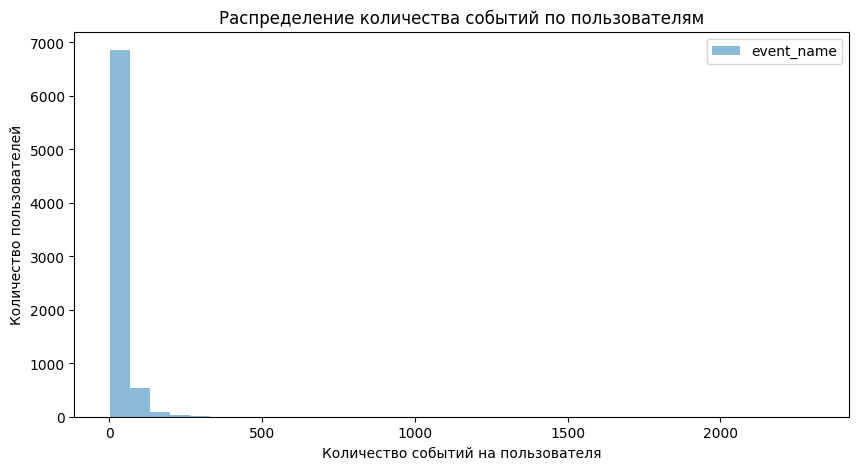

In [25]:
mean_ev.plot(figsize=(10,5), kind='hist', bins=35, alpha=0.5, title='Распределение количества событий по пользователям')

plt.xlabel('Количество событий на пользователя')
plt.ylabel('Количество пользователей')
plt.show()

Есть аномально активные пользователи, набравшие более 2000 действий в приложении за рассматриваемый период. Но в основном пользователи совершали до 50-100 событий за рассматриваемый период.

### Период в логе

In [26]:
print('Минимальная дата в логе', logs['dt'].min())

Минимальная дата в логе 2019-07-25 00:00:00


In [27]:
print('Максимальная дата в логе', logs['dt'].max())

Максимальная дата в логе 2019-08-07 00:00:00


**Построение столбчатой диаграммы, которая отобразит количество событий в зависимости от времени в разрезе групп.**

In [28]:
exp_table = logs.pivot_table(index = 'dt', columns = 'exp_id' , values = 'device_i_d_hash', aggfunc = 'count')
exp_table

exp_id,246,247,248
dt,,,
2019-07-25,4,1,4
2019-07-26,14,8,9
2019-07-27,24,23,8
2019-07-28,33,36,36
2019-07-29,55,58,71
2019-07-30,129,138,145
2019-07-31,620,664,746
2019-08-01,11561,12306,12274
2019-08-02,10946,10990,13618


In [29]:
df = exp_table.reset_index()

In [30]:
df.columns = ['dt', 'a1', 'a2','b']

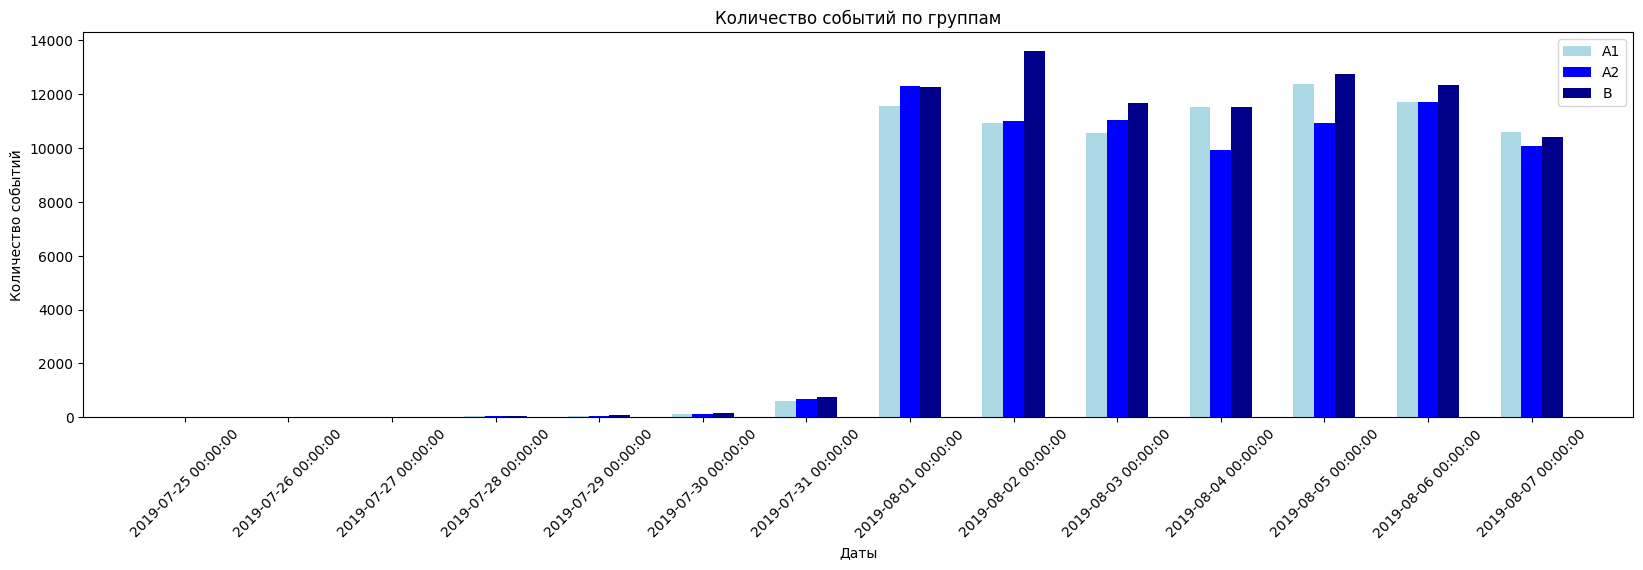

In [31]:
ax, fig = plt.subplots(figsize=(20,5))
 
X_axis = np.arange(df.shape[0]) 
 
rects = plt.bar(X_axis - 0.2, df['a1'], 0.2, label = 'A1', color = 'lightblue') 
plt.bar(X_axis, df['a2'], 0.2, label = 'A2', color  ='blue') 
plt.bar(X_axis + 0.2, df['b'], 0.2, label = 'B', color  ='darkblue') 
plt.xticks(X_axis, df['dt'], rotation=45) 

    
plt.xlabel('Даты') 
plt.ylabel('Количество событий') 
plt.title('Количество событий по группам') 
plt.legend() 
plt.show() 
 

График показывает, что до 01.08.2019 событий было зафиксировано в десятки раз меньше. Начиная с 01.08.19 количество событий  в день находится примерно на одном уровне в трех группах. По условиям задачи известно, что часть данных может быть искажена. Удалим данные, до 31.07.2019 включительно.

In [32]:
df_new = logs.query("dt >'2019-07-31'").copy()

In [33]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       240887 non-null  object        
 1   device_i_d_hash  240887 non-null  int64         
 2   event_timestamp  240887 non-null  int64         
 3   exp_id           240887 non-null  int64         
 4   date_time        240887 non-null  datetime64[ns]
 5   dt               240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 12.9+ MB


In [34]:
exp_table = df_new.pivot_table(index = 'dt', columns = 'exp_id' , values = 'device_i_d_hash', aggfunc = 'count')
exp_table

exp_id,246,247,248
dt,,,
2019-08-01,11561,12306,12274
2019-08-02,10946,10990,13618
2019-08-03,10575,11024,11683
2019-08-04,11514,9942,11512
2019-08-05,12368,10949,12741
2019-08-06,11726,11720,12342
2019-08-07,10612,10091,10393


In [35]:
count_event_1 = logs['event_name'].count()
count_event_2 = df_new['event_name'].count()
print('Количество потерянных событий после удаления части периода', count_event_1-count_event_2)
print('Процент потерянных событий:', f"{(count_event_1-count_event_2)/count_event_1:.1%}")

Количество потерянных событий после удаления части периода 2826
Процент потерянных событий: 1.2%


In [36]:
count_user_1 = logs['device_i_d_hash'].nunique()
count_user_2 = df_new['device_i_d_hash'].nunique()
print('Количество потерянных пользователей после удаления части периода', count_user_1-count_user_2)
print('Процент пользователей событий:', f"{(count_user_1-count_user_2)/count_user_1:.1%}")

Количество потерянных пользователей после удаления части периода 17
Процент пользователей событий: 0.2%


**После сокращения периода, потеря пользователей и событий в % кажется допустимой**

In [37]:
df_new

,event_name,device_i_d_hash,event_timestamp,exp_id,date_time,dt
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [38]:
df_new.groupby(by='exp_id').agg({'device_i_d_hash': 'nunique'})

,device_i_d_hash
exp_id,
246,2484
247,2513
248,2537


Проверили, что после удаления части данных, остались данные о пользователях из всех трех экспериментальных групп

## Шаг 4. Изучение воронки событий

### Проверка, какие события есть в логах, как часто они встречаются

In [39]:
df_new['event_name'].value_counts().sort_values(ascending=False)

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: count, dtype: int64


1. MainScreenAppear - просмотр главного экрана
2. OffersScreenAppear - просмотр экрана предложений
3. CartScreenAppear - просмотр корзины
4. PaymentScreenSuccessful - экран оплаты прошел успешно
5. Tutorial - руководство

In [40]:
df_new.head(1)

,event_name,device_i_d_hash,event_timestamp,exp_id,date_time,dt
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01


### Проверка, сколько пользователей совершали каждое из событий. Подсчет доли пользователей, которые хоть раз совершали событие.

In [41]:
result_1 = df_new.groupby('event_name').agg({'device_i_d_hash': 'nunique'}).rename(columns={'device_i_d_hash':'unique_us'}).reset_index()
result_1

,event_name,unique_us
0,CartScreenAppear,3734
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [42]:
df_new['device_i_d_hash'].nunique()

7534

In [43]:
result_1['count_us'] = 7534

In [44]:
result_1

,event_name,unique_us,count_us
0,CartScreenAppear,3734,7534
1,MainScreenAppear,7419,7534
2,OffersScreenAppear,4593,7534
3,PaymentScreenSuccessful,3539,7534
4,Tutorial,840,7534


In [45]:
result_1['ratio'] = round(result_1['unique_us']/result_1['count_us'],2)

In [46]:
result_1.sort_values(by='ratio', ascending = False)

,event_name,unique_us,count_us,ratio
1,MainScreenAppear,7419,7534,0.98
2,OffersScreenAppear,4593,7534,0.61
0,CartScreenAppear,3734,7534,0.50
3,PaymentScreenSuccessful,3539,7534,0.47
4,Tutorial,840,7534,0.11


- 98 % пользователей хотя бы раз заходили на главную страницу
- 61 % пользователей хотя бы раз посещали экран с предложением
- 50% хотя бы раз заходили в корзину
- 47% хотя бы раз производили оплату
- 11% хотя бы раз заглядывали в инструкцию


Рассчитали долю пользователей, которые хоть раз совершили событие. Из цифр можно сделать вывод, что в руководство заглядывают обычно 1 раз, иногда чаще. То есть пользователь ответил на свои вопросы и больше к руководству не возвращается. Остальные же события пользуются популярностью. Их пользователи посещают по много раз.


Похоже, что цепочка событий происходит так:
1. Главный экран
2. Изучение предложения
3. Корзина, добавление товара
4. Оплата

Посещение руководства не входит в цепочку и может происходить на любом этапе возникновения вопросов. Во свяком случае по цифрам в таблице, не удается сделать вывод, на каком этапе пользователи чаще всего обращаются к руководству.

### По воронке событий необходимо посчитать, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C

In [47]:
result_0 = df_new.groupby('event_name').agg({'device_i_d_hash':'nunique'}).sort_values(by='device_i_d_hash', ascending = False)
result_0 = result_0.drop(index = ['Tutorial'])
result_0['ratio'] =  (result_0['device_i_d_hash'].pct_change() + 1).fillna(1)
result_0 = round(result_0, 2)
result_0

,device_i_d_hash,ratio
event_name,,
MainScreenAppear,7419,1.00
OffersScreenAppear,4593,0.62
CartScreenAppear,3734,0.81
PaymentScreenSuccessful,3539,0.95


Больше всего пользователей теряется на этапе перехода с главного экрана на экран предложения. То есть пользователи смотрят главный экран и не идут дальше. В этот момент теряется 38% пользователей. От оставшихся 4593 пользователей 19% не переходят в корзину. На этапе корзины люди уже более-менее определились надо ли мы совершать покупку и из них НЕ оплачивает заказ 14%

### Доля пользователей, которые доходят от первого события до оплаты

In [48]:
print('Доля пользователей, которые доходят от главного экрана до оплаты', round(result_0.loc['PaymentScreenSuccessful', 'device_i_d_hash'] / result_0.loc['MainScreenAppear', 'device_i_d_hash'],2))

Доля пользователей, которые доходят от главного экрана до оплаты 0.48


## Шаг 5. Изучение результатов эксперимента

In [49]:
group_246 = df_new.query('exp_id == 246').copy()
event_246 = group_246['exp_id'].count()
users_246 = group_246['device_i_d_hash'].nunique()
print('Количество событий в группе А1', event_246)
print('Количетсво пользователей в группе А1', users_246)

Количество событий в группе А1 79302
Количетсво пользователей в группе А1 2484


In [50]:
group_247 = df_new.query('exp_id == 247').copy()
event_247 = group_247['exp_id'].count()
users_247 = group_247['device_i_d_hash'].nunique()
print('Количество событий в группе А2', event_247)
print('Количетсво пользователей в группе А2', users_247)

Количество событий в группе А2 77022
Количетсво пользователей в группе А2 2513


In [51]:
group_248 = df_new.query('exp_id == 248').copy()
event_248 = group_248['exp_id'].count()
users_248 = group_248['device_i_d_hash'].nunique()
print('Количество событий в группе B', event_248)
print('Количетсво пользователей в группе B', users_248)

Количество событий в группе B 84563
Количетсво пользователей в группе B 2537


### Функция для проверки статистической достоверности отличий доли пользователей, совершивших событие

In [52]:
def ration(one, two, event):

    alpha = .05


    group_one = df_new.query('exp_id == @one')
    group_two = df_new.query('exp_id == @two')

    users_one = group_one['device_i_d_hash'].nunique()
    users_two = group_two['device_i_d_hash'].nunique()

    event_one  = group_one[group_one['event_name']== event]['device_i_d_hash'].nunique()
    event_two = group_two[group_two['event_name']== event]['device_i_d_hash'].nunique()

    successes = np.array([event_one , event_two])
    trials = np.array([users_one, users_two])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

   # разница пропорций в датасетах
    difference = p1 - p2 

   # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

   # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 
        
    return ('p-значение: ', p_value)

**Формулировка гипотез**

- Нулевая гипотеза: между долями пользователей нет значимой разницы
- Альтернативная гипотеза: между долями пользователей на этапах есть значимая разница

- Уроверь статистической значимости alpha = 0.05
- Для проверки гипотезы считаем статистику в стандартных отклонениях стандартного нормального распределения

In [53]:
alpha = 0.05

#### Событие MainScreenAppear, группы А1/А2

In [54]:
ration(246, 247, 'MainScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.7570597232046099)

#### Событие OffersScreenAppear, группы А1/А2

In [55]:
ration(246, 247, 'OffersScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.2480954578522181)

#### Событие CartScreenAppear, группы А1/А2

In [56]:
ration(246, 247, 'CartScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.22883372237997213)

#### Событие PaymentScreenSuccessful, группы А1/А2

In [57]:
ration(246, 247, 'PaymentScreenSuccessful')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.11456679313141849)

**ВЫВОД**  А-группам показывали одинаковую старую версию шрифта.  Убедились, что нет статистически значимых различий между долями пользователей А-групп на разных этапах. То есть пользователи были поделены на группы корректно и результатам А/В теста можно будет доверять.

### Проверка статистической достоверности отличий доли пользователей совершивших событие в группе В и в группах А1, А2

#### Событие MainScreenAppear, группы А1/B

In [58]:
ration(246, 248, 'MainScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.2949721933554552)

#### Событие MainScreenAppear, группы А2/B

In [59]:
ration(247, 248, 'MainScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.4587053616621515)

#### Событие OffersScreenAppear, группы А1/B

In [60]:
ration(246, 248, 'OffersScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.20836205402738917)

#### Событие OffersScreenAppear, группы А2/B

In [61]:
ration(247, 248, 'OffersScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.9197817830592261)

#### Событие CartScreenAppear, группы А1/B

In [62]:
ration(246, 248, 'CartScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.07842923237520116)

#### Событие CartScreenAppear, группы А2/B

In [63]:
ration(247, 248, 'CartScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.5786197879539783)

#### Событие PaymentScreenSuccessful, группы А1/B

In [64]:
ration(246, 248, 'PaymentScreenSuccessful')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.2122553275697796)

#### Событие PaymentScreenSuccessful, группы А2/B

In [65]:
ration(247, 248, 'PaymentScreenSuccessful')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.7373415053803964)

### Проверка объединенной А-группы и В-группы

Доработаем функциию проверки под объединенную АА группу

In [66]:
df_246_247 = df_new.query('exp_id == 246 or exp_id == 247')

In [67]:
def ration_AA_B(event):

    alpha = .05


    group_one = df_246_247
    group_two = df_new.query('exp_id == 248')

    users_one = group_one['device_i_d_hash'].nunique()
    users_two = group_two['device_i_d_hash'].nunique()

    event_one  = group_one[group_one['event_name']== event]['device_i_d_hash'].nunique()
    event_two = group_two[group_two['event_name']== event]['device_i_d_hash'].nunique()

    successes = np.array([event_one , event_two])
    trials = np.array([users_one, users_two])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

   # разница пропорций в датасетах
    difference = p1 - p2 

   # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

   # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 
        
    return ('p-значение: ', p_value)

#### Событие MainScreenAppear, группы А+А/B

In [68]:
ration_AA_B('MainScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.29424526837179577)

#### Событие OffersScreenAppear, группы А+А/B

In [69]:
ration_AA_B('OffersScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.43425549655188256)

#### Событие CartScreenAppear, группы А+А/B

In [70]:
ration_AA_B('CartScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.18175875284404386)

#### Событие PaymentScreenSuccessful, группы А+А/B

In [71]:
ration_AA_B('PaymentScreenSuccessful')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.6004294282308704)

Ни на одном этапе не получилось отвергнуть нулевую гипотезу, между долями пользователей нет значимой разницы. Это касается и проверки между группами А1, А2. И проверки каждой из групп А с группой В. Получается изменение шрифта не повлияло на поведение пользователей. Они не стали чаще переходить на следующий этап воронки.

**Применим поправку Бонферонни для коррекции уровня значимости**. Разделим текущий уровень значимости 0.05 на 16, т к проводится 16 тестов. Тогда alpha = 0.003. Посчитаем результаты

In [72]:
def ration(one, two, event):

    alpha = .003


    group_one = df_new.query('exp_id == @one')
    group_two = df_new.query('exp_id == @two')

    users_one = group_one['device_i_d_hash'].nunique()
    users_two = group_two['device_i_d_hash'].nunique()

    event_one  = group_one[group_one['event_name']== event]['device_i_d_hash'].nunique()
    event_two = group_two[group_two['event_name']== event]['device_i_d_hash'].nunique()

    successes = np.array([event_one , event_two])
    trials = np.array([users_one, users_two])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

   # разница пропорций в датасетах
    difference = p1 - p2 

   # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

   # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 
        
    return ('p-значение: ', p_value)

#### Событие MainScreenAppear, группы А1/B, alpha = 0.003

In [73]:
ration(246, 248, 'MainScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.2949721933554552)

#### Событие OffersScreenAppear, группы А1/B, alpha = 0.003

In [74]:
ration(246, 248, 'OffersScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.20836205402738917)

#### Событие CartScreenAppear, группы А1/B, alpha = 0.003

In [75]:
ration(246, 248, 'CartScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.07842923237520116)

#### Событие PaymentScreenSuccessful, группы А1/B, alpha = 0.003

In [76]:
ration(246, 248, 'PaymentScreenSuccessful')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.2122553275697796)

#### Событие MainScreenAppear, группы А2/B, alpha = 0.003

In [77]:
ration(247, 248, 'MainScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.4587053616621515)

#### Событие OffersScreenAppear, группы А2/B, alpha = 0.003

In [78]:
ration(247, 248, 'OffersScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.9197817830592261)

#### Событие CartScreenAppear, группы А2/B, alpha = 0.003

In [79]:
ration(247, 248, 'CartScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.5786197879539783)

#### Событие PaymentScreenSuccessful, группы А2/B, alpha = 0.003

In [80]:
ration(247, 248, 'PaymentScreenSuccessful')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.7373415053803964)

#### Проверка объединенной А-группы и В-группы c поправкой Бонферрони

In [81]:
def ration_AA_B(event):

    alpha = .003


    group_one = df_246_247
    group_two = df_new.query('exp_id == 248')

    users_one = group_one['device_i_d_hash'].nunique()
    users_two = group_two['device_i_d_hash'].nunique()

    event_one  = group_one[group_one['event_name']== event]['device_i_d_hash'].nunique()
    event_two = group_two[group_two['event_name']== event]['device_i_d_hash'].nunique()

    successes = np.array([event_one , event_two])
    trials = np.array([users_one, users_two])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

   # разница пропорций в датасетах
    difference = p1 - p2 

   # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

   # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 
        
    return ('p-значение: ', p_value)

#### Событие MainScreenAppear, группы А+А/B

In [82]:
ration_AA_B('MainScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.29424526837179577)

#### Событие OffersScreenAppear, группы А+А/B

In [83]:
ration_AA_B('OffersScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.43425549655188256)

#### Событие CartScreenAppear, группы А+А/B

In [84]:
ration_AA_B('CartScreenAppear')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.18175875284404386)

#### Событие PaymentScreenSuccessful, группы А+А/B

In [85]:
ration_AA_B('PaymentScreenSuccessful')

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


('p-значение: ', 0.6004294282308704)

С уровнем статистической значимости = 0.003 также не удалось отвергнуть нулевую гипотезу, нет оснований считать доли пользователей на отдельных этапах разными

### Вывод

Ни на одном этапе не получилось отвергнуть нулевую гипотезу, между долями пользователей нет значимой разницы. Это касается и проверки между группами А1, А2. И проверки каждой из групп А с группой В, и сравнения объединенной группы А с группой В. Получается изменение шрифта не повлияло на поведение пользователей. Они не стали чаще переходить на следующий этап воронки.

Для проверки результатов эксперимента был выбран уровень значимости 0.05. Также была применена поправка Бонферрони - использовался уровень статистической значимости 0.025.

В процессе анализа и тестирования, была сформирована следующая воронка:

- Посещение главного экрана
- Посещение экрана с предложением
- Экран корзины
- Экран успешной оплаты

Основная потеря пользователей происходит после посещения главного экрана. Пользователи решают продолжать ли взаимодействие дальше или покинуть приложение.  В этот момент теряется 38% пользователей. От оставшихся 4593 пользователей 19% не переходят в корзину. На этапе корзины люди уже более-менее определились надо ли им совершать покупку и из них отказываются от оплаты заказа 14%

Доля пользователей, которые доходят от главного экрана до оплаты, составляет 48%